# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Porfolio dataframe

In [2]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
reward        10 non-null int64
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
offer_type    10 non-null object
id            10 non-null object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
portfolio.sort_values(by=['reward'])

,reward,channels,difficulty,duration,offer_type,id
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0


In [5]:
# encode offer id with more simple value, set the new column name = offer_id_2
portfolio = portfolio.reset_index()
portfolio.rename(columns={'index':'offer_id_2'}, inplace=True)

In [6]:
offer_id_2_dict = {list(portfolio['id'])[i]: list(portfolio['offer_id_2'])[i] for i in range(len(list(portfolio['id'])))} 

## Transcript dataframe

In [7]:
transcript.info()

# extract info from the 'value' column
    # create 4 separate dataframes: offer received, offer viewed,  offer completed, transaction, with values
        # offer received & offer received have offer_id_value 
        # offer completed has offer_id_value & offer_reward
        # transaction has transaction_value
    # check duplicate by each event type
        # if no duplicate, check % of total each event type account for
            # note that transaction has significantly high volume than offer received, this may mean that people purchase without offer

        

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
person    306534 non-null object
event     306534 non-null object
value     306534 non-null object
time      306534 non-null int64
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [8]:
transcript.groupby(['event'])['person'].count().sort_values

<bound method Series.sort_values of event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: person, dtype: int64>

### Offer received

In [9]:
offer_received = transcript[transcript['event'] == 'offer received']
offer_received = offer_received.reset_index()

offer_id_values = []

for i in range(len(offer_received)):
    offer_id_value = offer_received.value.values[i].get('offer id')
    offer_id_values.append(offer_id_value)

offer_received['offer_id_value'] = offer_id_values

In [10]:
# number of offer a person received
offer_received.groupby(['person'])['offer_id_value'].count().describe()

count    16994.000000
mean         4.488467
std          1.073047
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          6.000000
Name: offer_id_value, dtype: float64

In [11]:
# number of unique offer a person received
offer_received.groupby(['person'])['offer_id_value'].nunique().describe()

count    16994.000000
mean         3.724138
std          0.989462
min          1.000000
25%          3.000000
50%          4.000000
75%          4.000000
max          6.000000
Name: offer_id_value, dtype: float64

In [12]:
# number of offer received
offer_received_summary = pd.DataFrame(offer_received.groupby(['offer_id_value'])['person'].count())
offer_received_summary.rename(columns={'person':'offer_received'}, inplace=True)

In [13]:
# create a new column for simplier offer id using offer_id_2_dict dictionary
offer_received['offer_id_2'] = offer_received['offer_id_value']
offer_received['offer_id_2'].replace(offer_id_2_dict, inplace=True)

### Offer viewed

In [14]:
offer_viewed = transcript[transcript['event'] == 'offer viewed']
offer_viewed = offer_viewed.reset_index()

offer_id_values = []

for i in range(len(offer_viewed)):
    offer_id_value = offer_viewed.value.values[i].get('offer id')
    offer_id_values.append(offer_id_value)

offer_viewed['offer_id_value'] = offer_id_values

In [15]:
# number of offer viewed
offer_viewed_summary = pd.DataFrame(offer_viewed.groupby(['offer_id_value'])['person'].count())
offer_viewed_summary.rename(columns={'person':'offer_viewed'}, inplace=True)

In [16]:
# create a new column for simplier offer id using offer_id_2_dict dictionary
offer_viewed['offer_id_2'] = offer_viewed['offer_id_value']
offer_viewed['offer_id_2'].replace(offer_id_2_dict, inplace=True)

### Offer completed

In [17]:
offer_completed = transcript[transcript['event'] == 'offer completed']
offer_completed = offer_completed.reset_index()

offer_id_values = []
offer_rewards = []

for i in range(len(offer_completed)):
    offer_id_value = offer_completed.value.values[i].get('offer_id')
    offer_id_values.append(offer_id_value)
    
    offer_reward = offer_completed.value.values[i].get('reward')
    offer_rewards.append(offer_reward)

offer_completed['offer_id_value'] = offer_id_values
offer_completed['offer_reward'] = offer_rewards

In [18]:
# number of offer completed
offer_completed_summary = pd.DataFrame(offer_completed.groupby(['offer_id_value'])['person'].count())
offer_completed_summary.rename(columns={'person':'offer_completed'}, inplace=True)

In [19]:
# create a new column for simplier offer id using offer_id_2_dict dictionary
offer_completed['offer_id_2'] = offer_completed['offer_id_value']
offer_completed['offer_id_2'].replace(offer_id_2_dict, inplace=True)

### All offer events

In [20]:
frames = [offer_received, offer_viewed, offer_completed]
offer_all = pd.concat(frames)
offer_all

c:\users\sandy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,event,index,offer_id_2,offer_id_value,offer_reward,person,time,value
0,offer received,0,3,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,1,4,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,2,9,2906b810c7d4411798c6938adc9daaa5,NaN,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,3,6,fafdcd668e3743c1bb461111dcafc2a4,NaN,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,4,1,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
...,...,...,...,...,...,...,...,...
33574,offer completed,306475,5,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,0c027f5f34dd4b9eba0a25785c611273,714,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...
33575,offer completed,306497,5,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,a6f84f4e976f44508c358cc9aba6d2b3,714,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...
33576,offer completed,306506,6,fafdcd668e3743c1bb461111dcafc2a4,2.0,b895c57e8cd047a8872ce02aa54759d6,714,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
33577,offer completed,306509,6,fafdcd668e3743c1bb461111dcafc2a4,2.0,8431c16f8e1d440880db371a68f82dd0,714,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...


In [21]:
# number of offer received of each offer type by customer
offer_received_bycus = offer_received.groupby(['person','offer_id_2'])['event'].count().unstack().reset_index()
offer_received_bycus.rename(columns={
    0:'0_received',
    1:'1_received',
    2:'2_received',
    3:'3_received',
    4:'4_received',
    5:'5_received',
    6:'6_received',
    7:'7_received',
    8:'8_received',
    9:'9_received',
}, inplace=True)


In [22]:
offer_received_bycus.fillna(0, inplace=True)
offer_received_bycus

offer_id_2,person,0_received,1_received,2_received,3_received,4_received,5_received,6_received,7_received,8_received,9_received
0,0009655768c64bdeb2e877511632db8f,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
1,00116118485d4dfda04fdbaba9a87b5c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
2,0011e0d4e6b944f998e987f904e8c1e5,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
3,0020c2b971eb4e9188eac86d93036a77,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0
4,0020ccbbb6d84e358d3414a3ff76cffd,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
16989,fff3ba4757bd42088c044ca26d73817a,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,2.0
16990,fff7576017104bcc8677a8d63322b5e1,1.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0
16991,fff8957ea8b240a6b5e634b6ee8eafcf,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
16992,fffad4f4828548d1b5583907f2e9906b,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0


In [23]:
# number of offer viewed of each offer type by customer
offer_viewed_bycus = offer_viewed.groupby(['person','offer_id_2'])['event'].count().unstack().reset_index()
offer_viewed_bycus.rename(columns={
    0:'0_viewed',
    1:'1_viewed',
    2:'2_viewed',
    3:'3_viewed',
    4:'4_viewed',
    5:'5_viewed',
    6:'6_viewed',
    7:'7_viewed',
    8:'8_viewed',
    9:'9_viewed',
}, inplace=True)


In [24]:
# number of offer completed of each offer type by customer
offer_completed_bycus = offer_completed.groupby(['person','offer_id_2'])['event'].count().unstack().reset_index()
offer_completed_bycus.rename(columns={
    0:'0_completed',
    1:'1_completed',
    2:'2_completed',
    3:'3_completed',
    4:'4_completed',
    5:'5_completed',
    6:'6_completed',
    7:'7_completed',
    8:'8_completed',
    9:'9_completed',
}, inplace=True)


In [25]:
offer_received_bycus.shape[0]

16994

In [26]:
offer_viewed_bycus.shape[0]

16834

In [27]:
offer_completed_bycus.shape[0]

12774

### Transaction

In [28]:
transaction = transcript[transcript['event'] == 'transaction']
transaction = transaction.reset_index()

transaction_values = []

for i in range(len(transaction)):
    transaction_value = transaction.value.values[i].get('amount')
    
    if type(transaction_value) == float:
        transaction_value = round(transaction_value, 2)
        
    transaction_values.append(transaction_value)

transaction['transaction_value'] = transaction_values

In [29]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138953 entries, 0 to 138952
Data columns (total 6 columns):
index                138953 non-null int64
person               138953 non-null object
event                138953 non-null object
value                138953 non-null object
time                 138953 non-null int64
transaction_value    138953 non-null float64
dtypes: float64(1), int64(2), object(3)
memory usage: 6.4+ MB


In [30]:
transaction.describe()

,index,time,transaction_value
count,138953.000000,138953.000000,138953.000000
mean,160710.678676,381.584334,12.777356
std,90463.542633,201.697230,30.250529
min,12654.000000,0.000000,0.050000
25%,85177.000000,210.000000,2.780000
50%,150201.000000,402.000000,8.890000
75%,239167.000000,552.000000,18.070000
max,306533.000000,714.000000,1062.280000


### Summary of offer received, viewed & completed

In [31]:
frames = [offer_received_summary, offer_viewed_summary, offer_completed_summary]
offer_summary = pd.concat(frames, axis=1, sort=False)

In [32]:
offer_summary

,offer_received,offer_viewed,offer_completed
0b1e1539f2cc45b7b9fa7c272da2e1d7,7668,2663,3420.0
2298d6c36e964ae4a3e7e9706d1fb8c2,7646,7337,5156.0
2906b810c7d4411798c6938adc9daaa5,7632,4118,4017.0
3f207df678b143eea3cee63160fa8bed,7617,4144,NaN
4d5c57ea9a6940dd891ad53e9dbe8da0,7593,7298,3331.0
5a8bc65990b245e5a138643cd4eb9837,7618,6687,NaN
9b98b8c7a33c4b65b9aebfe6a799e6d9,7677,4171,4354.0
ae264e3637204a6fb9bb56bc8210ddfd,7658,6716,3688.0
f19421c1d4aa40978ebb69ca19b0e20d,7571,7264,4296.0
fafdcd668e3743c1bb461111dcafc2a4,7597,7327,5317.0


In [33]:
offer_summary = pd.concat([offer_summary, portfolio.set_index('id')], axis=1, sort=False)

In [34]:
offer_summary

,offer_received,offer_viewed,offer_completed,offer_id_2,reward,channels,difficulty,duration,offer_type
0b1e1539f2cc45b7b9fa7c272da2e1d7,7668,2663,3420.0,4,5,"[web, email]",20,10,discount
2298d6c36e964ae4a3e7e9706d1fb8c2,7646,7337,5156.0,5,3,"[web, email, mobile, social]",7,7,discount
2906b810c7d4411798c6938adc9daaa5,7632,4118,4017.0,9,2,"[web, email, mobile]",10,7,discount
3f207df678b143eea3cee63160fa8bed,7617,4144,NaN,2,0,"[web, email, mobile]",0,4,informational
4d5c57ea9a6940dd891ad53e9dbe8da0,7593,7298,3331.0,1,10,"[web, email, mobile, social]",10,5,bogo
5a8bc65990b245e5a138643cd4eb9837,7618,6687,NaN,7,0,"[email, mobile, social]",0,3,informational
9b98b8c7a33c4b65b9aebfe6a799e6d9,7677,4171,4354.0,3,5,"[web, email, mobile]",5,7,bogo
ae264e3637204a6fb9bb56bc8210ddfd,7658,6716,3688.0,0,10,"[email, mobile, social]",10,7,bogo
f19421c1d4aa40978ebb69ca19b0e20d,7571,7264,4296.0,8,5,"[web, email, mobile, social]",5,5,bogo
fafdcd668e3743c1bb461111dcafc2a4,7597,7327,5317.0,6,2,"[web, email, mobile, social]",10,10,discount


In [35]:
offer_summary = offer_summary.reset_index()
offer_summary.rename(columns={'index':'offer_id'}, inplace=True)

In [36]:
offer_summary

,offer_id,offer_received,offer_viewed,offer_completed,offer_id_2,reward,channels,difficulty,duration,offer_type
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,7668,2663,3420.0,4,5,"[web, email]",20,10,discount
1,2298d6c36e964ae4a3e7e9706d1fb8c2,7646,7337,5156.0,5,3,"[web, email, mobile, social]",7,7,discount
2,2906b810c7d4411798c6938adc9daaa5,7632,4118,4017.0,9,2,"[web, email, mobile]",10,7,discount
3,3f207df678b143eea3cee63160fa8bed,7617,4144,NaN,2,0,"[web, email, mobile]",0,4,informational
4,4d5c57ea9a6940dd891ad53e9dbe8da0,7593,7298,3331.0,1,10,"[web, email, mobile, social]",10,5,bogo
5,5a8bc65990b245e5a138643cd4eb9837,7618,6687,NaN,7,0,"[email, mobile, social]",0,3,informational
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,7677,4171,4354.0,3,5,"[web, email, mobile]",5,7,bogo
7,ae264e3637204a6fb9bb56bc8210ddfd,7658,6716,3688.0,0,10,"[email, mobile, social]",10,7,bogo
8,f19421c1d4aa40978ebb69ca19b0e20d,7571,7264,4296.0,8,5,"[web, email, mobile, social]",5,5,bogo
9,fafdcd668e3743c1bb461111dcafc2a4,7597,7327,5317.0,6,2,"[web, email, mobile, social]",10,10,discount


# Profile dataframe

In [37]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
id                  17000 non-null object
became_member_on    17000 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [38]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [39]:
profile_offer_received = pd.concat([offer_received_bycus.set_index('person'), profile.set_index('id')], axis=1, sort=False)

In [40]:
profile_offer_received = profile_offer_received.reset_index()
profile_offer_received

,index,0_received,1_received,2_received,3_received,4_received,5_received,6_received,7_received,8_received,9_received,gender,age,became_member_on,income
0,0009655768c64bdeb2e877511632db8f,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,M,33,20170421,72000.0
1,00116118485d4dfda04fdbaba9a87b5c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,None,118,20180425,NaN
2,0011e0d4e6b944f998e987f904e8c1e5,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,O,40,20180109,57000.0
3,0020c2b971eb4e9188eac86d93036a77,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,F,59,20160304,90000.0
4,0020ccbbb6d84e358d3414a3ff76cffd,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,F,24,20161111,60000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,da7a7c0dcfcb41a8acc7864a53cf60fb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,118,20170801,NaN
16996,eb540099db834cf59001f83a4561aef3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,66,20170929,34000.0
16997,3a4874d8f0ef42b9a1b72294902afea9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,55,20160816,88000.0
16998,ae8111e7e8cd4b60a8d35c42c1110555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,54,20170106,72000.0


In [41]:
profile_offer_received.dropna(axis=0, how='any', inplace=True)

In [43]:
profile_offer_received.columns

Index(['index', '0_received', '1_received', '2_received', '3_received',
       '4_received', '5_received', '6_received', '7_received', '8_received',
       '9_received', 'gender', 'age', 'became_member_on', 'income'],
      dtype='object')

In [47]:
profile_offer_received = profile_offer_received[['0_received', '1_received', '2_received', '3_received',
       '4_received', '5_received', '6_received', '7_received', '8_received',
       '9_received', 'age', 'income']]

In [48]:
profile_offer_received

,0_received,1_received,2_received,3_received,4_received,5_received,6_received,7_received,8_received,9_received,age,income
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,33,72000.0
2,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,40,57000.0
3,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,59,90000.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,24,60000.0
5,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,26,73000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
16989,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,2.0,69,83000.0
16990,1.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,71,73000.0
16991,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,71,56000.0
16992,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,34,34000.0


### Customer segmentation

In [49]:
cols = profile_offer_received.columns

zcols = []

for col in cols:
    
    profile_offer_received['z_' + col] = (profile_offer_received[col] - profile_offer_received[col].mean())/profile_offer_received[col].std()
    
    zcols.append('z_' + col)

In [50]:
profile_offer_received

,0_received,1_received,2_received,3_received,4_received,5_received,6_received,7_received,8_received,9_received,...,z_2_received,z_3_received,z_4_received,z_5_received,z_6_received,z_7_received,z_8_received,z_9_received,z_age,z_income
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.853992,-0.697965,-0.702479,-0.693769,0.859585,0.855417,0.863354,0.853168,-1.230447,0.305264
2,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.853992,0.849356,0.845356,0.851183,-0.700044,0.855417,-0.688672,-0.690849,-0.827759,-0.389242
3,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,...,-0.696438,-0.697965,-0.702479,-0.693769,2.419214,0.855417,-0.688672,-0.690849,0.265253,1.138673
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,-0.696438,0.849356,-0.702479,0.851183,-0.700044,0.855417,0.863354,-0.690849,-1.748189,-0.250341
5,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,...,0.853992,-0.697965,0.845356,-0.693769,2.419214,0.855417,-0.688672,-0.690849,-1.633135,0.351565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16989,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,2.0,...,-0.696438,0.849356,-0.702479,-0.693769,0.859585,2.405776,-0.688672,2.397186,0.840522,0.814569
16990,1.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,...,-0.696438,0.849356,-0.702479,-0.693769,2.419214,-0.694941,-0.688672,-0.690849,0.955575,0.351565
16991,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.853992,-0.697965,-0.702479,-0.693769,0.859585,-0.694941,-0.688672,-0.690849,0.955575,-0.435543
16992,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,...,-0.696438,0.849356,-0.702479,-0.693769,-0.700044,0.855417,2.415379,-0.690849,-1.172920,-1.454153


In [ ]:
from sklearn import cluster

model = cluster.KMeans(n_clusters=4, random_state=10)

df['cluster'] = model.fit_predict(df[zcols])

In [51]:
zcols

['z_0_received',
 'z_1_received',
 'z_2_received',
 'z_3_received',
 'z_4_received',
 'z_5_received',
 'z_6_received',
 'z_7_received',
 'z_8_received',
 'z_9_received',
 'z_age',
 'z_income']

In [52]:
from sklearn import cluster

model = cluster.KMeans(n_clusters=2, random_state=10)

X = profile_offer_received[zcols].as_matrix()

model.fit_predict(X)

cluster_assignments = model.labels_

centers = model.cluster_centers_

c:\users\sandy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [53]:
print(np.sum((X - centers[cluster_assignments]) ** 2))

164620.7559617317


In [59]:
ss = []

krange = list(range(2,30))

X = profile_offer_received[zcols].values

for n in krange:
    model = cluster.KMeans(n_clusters=n, random_state=10)
    
    model.fit_predict(X)
    
    cluster_assignments = model.labels_
    
    centers = model.cluster_centers_
    
    ss.append(np.sum((X - centers[cluster_assignments]) ** 2))

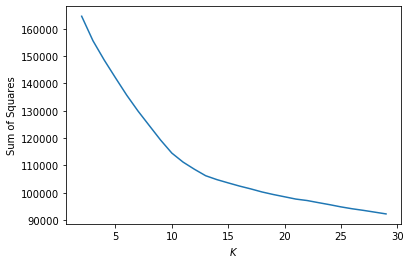

In [60]:
plt.plot(krange, ss)

plt.xlabel("$K$")

plt.ylabel("Sum of Squares")

plt.show()

In [65]:
model = cluster.KMeans(n_clusters=10, random_state=10)

profile_offer_received['cluster'] = model.fit_predict(profile_offer_received[zcols])

In [66]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)

profile_offer_received['pc1'], profile_offer_received['pc2'] = zip(*pca.fit_transform(profile_offer_received[zcols]))

In [68]:
profile_offer_received['cluster'].unique()

array([0, 8, 6, 1, 9, 2, 3, 4, 7, 5], dtype=int64)

In [76]:
profile_offer_received.columns

Index(['0_received', '1_received', '2_received', '3_received', '4_received',
       '5_received', '6_received', '7_received', '8_received', '9_received',
       'age', 'income', 'z_0_received', 'z_1_received', 'z_2_received',
       'z_3_received', 'z_4_received', 'z_5_received', 'z_6_received',
       'z_7_received', 'z_8_received', 'z_9_received', 'z_age', 'z_income',
       'cluster', 'pc1', 'pc2'],
      dtype='object')

In [77]:
for cluster in profile_offer_received['cluster'].unique():
    
    print("Cluster: " + str(cluster))
    
    for col in ['0_received', '1_received', '2_received', '3_received', '4_received',
       '5_received', '6_received', '7_received', '8_received', '9_received',
       'age', 'income']:
        print(col + ": {:.2f}".format(profile_offer_received.loc[profile_offer_received['cluster'] == cluster, col].mean()))

Cluster: 0
0_received: 0.34
1_received: 0.34
2_received: 0.38
3_received: 0.34
4_received: 0.34
5_received: 0.34
6_received: 1.31
7_received: 0.29
8_received: 0.35
9_received: 0.36
age: 52.94
income: 62946.36
Cluster: 8
0_received: 0.33
1_received: 0.39
2_received: 1.59
3_received: 0.40
4_received: 0.34
5_received: 0.38
6_received: 0.13
7_received: 0.30
8_received: 0.37
9_received: 0.13
age: 53.62
income: 63025.23
Cluster: 6
0_received: 0.38
1_received: 0.36
2_received: 0.16
3_received: 0.36
4_received: 0.36
5_received: 0.40
6_received: 0.19
7_received: 0.29
8_received: 1.74
9_received: 0.17
age: 53.47
income: 63555.14
Cluster: 1
0_received: 0.37
1_received: 0.34
2_received: 0.37
3_received: 0.37
4_received: 0.37
5_received: 0.33
6_received: 0.11
7_received: 0.29
8_received: 0.38
9_received: 1.45
age: 52.30
income: 63066.08
Cluster: 9
0_received: 2.12
1_received: 0.25
2_received: 0.33
3_received: 0.28
4_received: 0.26
5_received: 0.33
6_received: 0.33
7_received: 0.29
8_received: 0.26
